<center><a href="https://5loi.com/about_loi"> <img src="images/DLI_Header.png" alt="Header" style="width: 400px;"/> </a></center>

# 1. 从 U-Net 到扩散模型

｜ From U-Net to Diffusion



U-Net 是一种卷积神经网络（convolutional neural network），最初设计用于医学图像处理。例如，我们可以向网络输入心脏的图像，它可以返回另一张突出显示潜在癌变区域的图像。

我们能否使用此过程生成新的图像？这里有一个想法：如果我们向图像添加噪声，然后使用 U-Net 将图像与噪声分离，会怎么样？然后，我们能否向模型输入噪声并让它创建可识别的图像？让我们试一试！


#### 学习目标

本笔记本的目标是：
* 探索 FashionMNIST 数据集
* 构建 U-Net 架构
  * 构建下采样块（Down Block）
  * 构建上采样块（Up Block）
* 训练一个模型来去除图像中的噪声
* 尝试生成服装图片

In [1]:
# 导入 PyTorch 库
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

# 导入可视化工具
import graphviz
from torchview import draw_graph
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt


在 PyTorch 中，我们可以通过将 [设备](https://pytorch.org/docs/stable/tensor_attributes.html#torch.device) 设置为 `cuda` 来在操作中使用 GPU。函数 `torch.cuda.is_available()` 将确认 PyTorch 是否能够识别 GPU。

In [2]:
# 查看 NVIDIA GPU 的状态和信息。
!nvidia-smi 


Wed Sep 25 09:28:16 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   25C    P8    14W / 300W |      0MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# 检查 GPU 是否可用，如果可用则使用 GPU，否则使用 CPU。
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

# 打印 GPU 是否可用
torch.cuda.is_available() 


True

## 1.1 数据集
| The Dataset

为了练习生成图像，我们将使用 [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist) 数据集。FashionMNIST 被设计为图像分类问题的“Hello World”数据集。黑白图像的小尺寸（28 x 28 像素）也使其成为图像生成的理想起点。

FashionMNIST 包含在 [Torchvision](https://pytorch.org/vision/stable/index.html) 中，这是一个与 PyTorch 相关的计算机视觉库。当我们下载数据集时，我们可以传递一个 [转换(transformations)](https://pytorch.org/vision/stable/transforms.html) 列表，这些转换是我们希望应用于图像的。现在，我们将使用 [ToTensor](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor) 将图像转换为张量，以便我们可以使用神经网络来处理图像。这将自动将像素值从 [0, 255] 缩放至 [0, 1]。它还会将尺寸重新排列为从 [高度 x 宽度 x 通道] 变为 [通道 x 高度 x 宽度]。


In [4]:
# 从 FashionMNIST 数据集中加载训练集，并指定数据保存路径、是否下载数据和数据转换方式。
train_set = torchvision.datasets.FashionMNIST(
    "./data/", download=True, transform=transforms.Compose([transforms.ToTensor()])
)

# 定义 FashionMNIST 数据集的类别数量。
NUM_CLASSES = 10


100%|██████████| 26421880/26421880 [00:02<00:00, 13115599.26it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 329537.94it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6090372.97it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13814636.59it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



我们可以使用下面的代码来对一些图像进行采样：

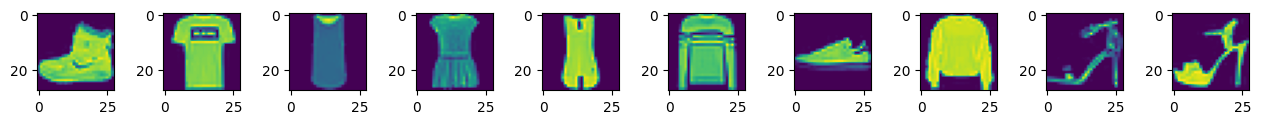

In [5]:
# 调整图形大小，推荐使用高宽比
plt.figure(figsize=(16, 1))

# 定义一个函数，用于显示数据集中的图像
def show_images(dataset, num_samples=10):
    # 遍历数据集
    for i, img in enumerate(dataset):
        # 如果已经显示了指定数量的图像，则停止循环
        if i == num_samples:
            return
        # 在子图中显示图像
        plt.subplot(1, num_samples, i + 1)
        plt.imshow(torch.squeeze(img[0]))

# 使用 show_images 函数显示训练集中的一些图像
show_images(train_set)


让我们为数据集设置一些导入常量。在使用 U-Net 时，通常会通过 [最大池化(Max Pooling)](https://paperswithcode.com/method/max-pooling) 不断地将特征图的大小减半。然后，使用 [转置卷积(Transposed Convolution)](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) 将特征图大小加倍。为了在上下移动 U-Net 时保持图像尺寸一致，如果图像尺寸可以被 `2` 多次整除，则会有所帮助。


In [6]:
# 设置图像的大小。由于步长和池化操作，图像大小必须可以被 2 整除多次。
IMG_SIZE = 16 

# 设置图像的通道数量。由于是黑白图像，所以通道数量为 1。
IMG_CH = 1 

# 设置批次大小。
BATCH_SIZE = 128


现在我们已经定义了图像的目标大小，让我们创建一个函数来加载数据并将其转换为目标大小。我们将添加到图像中的随机噪声将从 [标准正态分布(standard normal distribution)](https://mathworld.wolfram.com/NormalDistribution.html) 中采样，这意味着 68% 的噪声像素值将介于 -1 到 1 之间。我们也将类似地将图像值缩放至 -1 到 1 之间。

这将是一个应用随机图像增强的理想位置。现在，我们将从 [随机水平翻转(RandomHorizontalFlip)](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomHorizontalFlip.html#torchvision.transforms.RandomHorizontalFlip) 开始。我们不会使用 [随机垂直翻转(RandomVericalFlip)](https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomVerticalFlip.html#torchvision.transforms.RandomVerticalFlip)，因为我们最终会生成上下颠倒的图像。


In [7]:
# 定义一个函数，用于加载 FashionMNIST 数据集。
def load_fashionMNIST(data_transform, train=True):
    # 从 FashionMNIST 数据集中加载训练集或测试集，并指定数据保存路径、是否下载数据、是否为训练集以及数据转换方式。
    return torchvision.datasets.FashionMNIST(
        "./",
        download=True,
        train=train,
        transform=data_transform,
    )


# 定义一个函数，用于加载经过转换的 FashionMNIST 数据集。
def load_transformed_fashionMNIST():
    # 定义数据转换步骤，包括：
    #  - 调整图像大小为 IMG_SIZE x IMG_SIZE。
    #  - 将图像转换为张量，并缩放至 [0, 1] 区间。
    #  - 随机水平翻转图像。
    #  - 将图像值缩放至 [-1, 1] 区间。
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),  # 缩放至 [0,1]
        transforms.RandomHorizontalFlip(),
        transforms.Lambda(lambda t: (t * 2) - 1)  # 缩放至 [-1, 1]
    ]

    # 使用 Compose 将数据转换步骤组合在一起。
    data_transform = transforms.Compose(data_transforms)

    # 加载经过转换的训练集和测试集。
    train_set = load_fashionMNIST(data_transform, train=True)
    test_set = load_fashionMNIST(data_transform, train=False)

    # 将训练集和测试集连接在一起，并将它们作为 ConcatDataset 返回。
    return torch.utils.data.ConcatDataset([train_set, test_set])


In [8]:
# 加载经过转换的 FashionMNIST 数据集。
data = load_transformed_fashionMNIST()

# 使用 DataLoader 创建数据加载器，用于将数据集分成批次，并指定批次大小、是否进行随机打乱以及是否丢弃最后一个不完整的批次。
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)


100%|██████████| 26421880/26421880 [00:01<00:00, 14664646.96it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 329247.84it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 6089435.18it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 14103381.44it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



## 1.2 U-Net 架构
| The U-Net Architecture

首先，让我们定义 U-Net 架构的不同组件。主要是 `DownBlock` 和 `UpBlock`。

### 1.2.1 下降块
| The Down Block

`DownBlock` 是一个典型的卷积神经网络。如果您不熟悉 PyTorch，并且来自 Keras/TensorFlow 背景，那么以下内容更类似于 [函数式(functional) API](https://keras.io/guides/functional_api/) 而不是 [顺序模型(sequential model)](https://keras.io/guides/sequential_model/)。我们之后将使用 [残差(residual)](https://stats.stackexchange.com/questions/321054/what-are-residual-connections-in-rnns) 和跳跃连接。顺序模型没有足够的灵活性来支持这些类型的连接，但函数式模型可以。

在我们下面的 `__init__` 函数中，我们将把各种神经网络操作分配给类变量：
* [Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html) 将卷积应用于输入。`in_ch` 是我们正在进行卷积的通道数量，而 `out_ch` 是输出通道的数量，它与用于卷积的内核过滤器数量相同。在 U-Net 架构中，一般来说，通道数量随着我们向下移动模型而增加。
* [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html) 是卷积内核的激活函数。
* [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html) 将 [批次归一化(batch normalization)](https://towardsdatascience.com/batch-normalization-in-3-levels-of-understanding-14c2da90a338) 应用于神经元层。ReLU 没有可学习的参数，因此我们可以将同一个函数应用于多个层，其效果与使用多个 ReLU 函数相同。批次归一化确实具有可学习的参数，并且重复使用此函数可能会产生意想不到的效果。
* [MaxPool2D](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html) 是我们在特征图向下移动网络时用来减小其大小的东西。可以通过卷积来实现这种效果，但最大池化通常与 U-Net 一起使用。

在 `forward` 方法中，我们描述了各种函数应该如何应用于输入。到目前为止，操作按以下顺序进行：
* `Conv2d`
* `BatchNorm2d`
* `ReLU`
* `Conv2d`
* `BatchNorm2d`
* `ReLU`
* `MaxPool2d`


In [9]:
class DownBlock(nn.Module):
    # 定义下降块的初始化函数。
    def __init__(self, in_ch, out_ch):
        # 设置卷积核大小、步长和填充大小。
        kernel_size = 3
        stride = 1
        padding = 1

        # 初始化父类。
        super().__init__()

        # 定义下降块的网络层，包括：
        #  - 卷积层：使用 Conv2d 将输入通道数 in_ch 转换为输出通道数 out_ch，并设置卷积核大小、步长和填充大小。
        #  - 批次归一化层：使用 BatchNorm2d 对卷积层的输出进行批次归一化。
        #  - ReLU 激活函数：使用 ReLU 对批次归一化后的结果进行激活。
        #  - 另一个卷积层：使用 Conv2d 将输出通道数 out_ch 转换为 out_ch，并设置卷积核大小、步长和填充大小。
        #  - 另一个批次归一化层：使用 BatchNorm2d 对卷积层的输出进行批次归一化。
        #  - 另一个 ReLU 激活函数：使用 ReLU 对批次归一化后的结果进行激活。
        #  - 最大池化层：使用 MaxPool2d 对激活后的结果进行降采样，池化窗口大小为 2。
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ]
        # 使用 nn.Sequential 将网络层串联在一起。
        self.model = nn.Sequential(*layers)


    # 定义下降块的前向传播函数。
    def forward(self, x):
        # 将输入数据通过网络层进行前向传播。
        return self.model(x)


### 1.2.2 上升块
| The Up Block

虽然 `DownBlock` 减少了特征图的大小，但 `UpBlock` 会将其大小加倍。这是通过 [ConvTranspose2d](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) 来实现的。我们可以使用几乎与 `DownBlock` 相同的架构，但我们将用 convT 替换 conv2。转置的 `stride` 为 2 将导致使用正确数量的 `padding` 来加倍。

让我们通过下面的代码块来练习一下。我们设置了一个示例，通过创建一个值为 1 的测试图像来测试这个函数。


In [10]:
# 设置输入数据的通道数、高度和宽度。
ch, h, w = 1, 3, 3

# 创建一个形状为 (1, ch, h, w) 的张量，所有元素都为 1。
x = torch.ones(1, ch, h, w)

# 打印张量。
x


tensor([[[[1., 1., 1.],
          [1., 1., 1.],
          [1., 1., 1.]]]])

我们可以使用恒等 `kernel` 来查看 `conv_transpose2d` 如何改变输入图像。恒等内核具有单个值 1。当用于卷积时，输出将与输入相同。

尝试更改下面的 `stride`、`padding` 和 `output_padding`。结果是否符合您的预期？

In [11]:
kernel = torch.tensor([[1.]])  # 创建一个 1x1 的单位矩阵，作为卷积核
kernel = kernel.view(1, 1, 1, 1).repeat(1, ch, 1, 1) # 将单位矩阵 reshape 为 (1, ch, 1, 1) 的形状，并重复 ch 次，使其成为一个批次

output = F.conv_transpose2d(x, kernel, stride=1, padding=0, output_padding=0)[0] # 使用转置卷积操作，将输入特征图 x 与卷积核 kernel 进行卷积，得到输出特征图 output
output # 输出 output 


tensor([[[1., 1., 1.],
         [1., 1., 1.],
         [1., 1., 1.]]])

**代码逻辑解释:**

* **创建单位矩阵卷积核:**
    * `kernel = torch.tensor([[1.]])`: 创建一个 1x1 的单位矩阵，作为卷积核。
    * `kernel = kernel.view(1, 1, 1, 1).repeat(1, ch, 1, 1)`: 
        * 将单位矩阵 reshape 为 (1, ch, 1, 1) 的形状，其中 ch 是输入特征图的通道数。
        * 将 reshape 后的矩阵重复 ch 次，形成一个批次 (batch)，这样就能对每个通道进行独立的转置卷积操作。

* **转置卷积操作:** 
    * `F.conv_transpose2d(x, kernel, stride=1, padding=0, output_padding=0)[0]`: 
        * 使用 `F.conv_transpose2d` 函数进行转置卷积操作。
        * `x`: 输入特征图。
        * `kernel`: 单位矩阵卷积核。
        * `stride=1`: 步长为 1，表示卷积核在特征图上每次移动一个像素。
        * `padding=0`:  填充为 0，表示不进行填充操作。
        * `output_padding=0`: 输出填充为 0，表示不进行输出填充操作。
        * `[0]`: 获取批次中的第一个元素，也就是实际的输出特征图。

* **输出结果:**
    * `output`: 使用 `print(output)` 可以查看输出特征图的内容。


**代码功能:**

这段代码使用转置卷积操作，并将卷积核设置为单位矩阵，实际上相当于对输入特征图进行“反卷积”，将每个像素的特征信息复制到输出特征图中，不改变特征图的尺寸，也不改变特征信息的内容。 

这是一种简单的方式，可以对输入特征图进行复制，方便在某些场景下进行操作，例如将特征图复制到特定位置，或用于进行特征图的可视化操作。


内核大小也会影响输出特征图的大小。尝试更改下面的 `kernel_size`。注意，随着内核大小的增加，输出图像如何扩展？这与常规卷积(regular convolution)相反，在常规卷积中，较大的内核大小会减小输出特征图的大小。


In [12]:
kernel_size = 3  # 定义卷积核的大小为 3x3
kernel = torch.ones(1, 1, kernel_size, kernel_size) # 创建一个 3x3 的全 1 矩阵，尺寸为 (1, 1, kernel_size, kernel_size)

output = F.conv_transpose2d(x, kernel, stride=1, padding=0, output_padding=0)[0] # 对输入特征图 x 进行转置卷积操作
output # 输出结果


tensor([[[1., 2., 3., 2., 1.],
         [2., 4., 6., 4., 2.],
         [3., 6., 9., 6., 3.],
         [2., 4., 6., 4., 2.],
         [1., 2., 3., 2., 1.]]])

**代码逻辑解释:**

* **创建卷积核:**
   - `kernel_size = 3`: 设置卷积核的大小为 3x3。
   - `kernel = torch.ones(1, 1, kernel_size, kernel_size)`:  创建一个全 1 的矩阵，尺寸为 (1, 1, kernel_size, kernel_size)，作为转置卷积核。

* **转置卷积操作:**
   - `output = F.conv_transpose2d(x, kernel, stride=1, padding=0, output_padding=0)[0]`: 
     - 使用 `F.conv_transpose2d` 函数对输入特征图 `x` 进行转置卷积操作。
     - `kernel`: 创建的 3x3 全 1 矩阵。
     - `stride=1`: 步长为 1。
     - `padding=0`: 填充为 0。
     - `output_padding=0`: 输出填充为 0。
     - `[0]`: 提取批次中的第一个元素，也就是实际的输出特征图。

* **输出结果:**
   - `output`:  存储转置卷积后的输出结果。


**代码功能:**

这段代码使用一个 3x3 的全 1 矩阵作为卷积核进行转置卷积操作。由于卷积核中全是 1，因此它相当于对输入特征图进行**平均操作**，每个像素的输出值是其周围 9 个像素的平均值，这会导致输出特征图变得更加平滑。

这种操作可以用于**特征图的降噪**，但由于它会模糊特征，所以需要注意它的使用场景。


另一个有趣的区别：我们将把输入通道乘以 2。这是为了适应跳跃连接。我们将把 `UpBlock` 匹配的 `DownBlock` 的输出与其对应的 `DownBlock` 的输入连接起来。

<center><img src="images/FMUNet.png" width="600" /></center>

如果 x 是输入特征图的大小，则输出大小为：

`new_x = (x - 1) * stride + kernel_size - 2 * padding + out_padding`

如果 stride = 2 并且 out_padding = 1，那么为了将输入特征图的大小加倍：

`kernel_size = 2 * padding + 1`

操作几乎与以前相同，但有两个区别：
* `ConvTranspose2d` - 转置卷积而不是卷积
* `BatchNorm2d`
* `ReLU`
* `Conv2d`
* `BatchNorm2d`
* `ReLU`
* ~~`MaxPool2d`~~ - 缩放向上而不是向下


In [13]:
class UpBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        # 卷积参数
        kernel_size = 3
        stride = 1
        padding = 1

        # 转置卷积参数
        strideT = 2
        out_paddingT = 1

        super().__init__()
        # 2 * in_chs 用于连接跳跃连接 (skip connection)
        layers = [
            nn.ConvTranspose2d(2 * in_ch, out_ch, kernel_size, strideT, padding, out_paddingT), # 转置卷积层，将特征图尺寸扩大
            nn.BatchNorm2d(out_ch), # 批次归一化层，用于稳定训练
            nn.ReLU(), # ReLU 激活函数，用于引入非线性
            nn.Conv2d(out_ch, out_ch, kernel_size, stride, padding), # 卷积层，用于提取特征
            nn.BatchNorm2d(out_ch), # 批次归一化层
            nn.ReLU() # ReLU 激活函数
        ]
        self.model = nn.Sequential(*layers) # 将这些层组合成一个顺序模型
    
    def forward(self, x, skip):
        x = torch.cat((x, skip), 1) # 将输入特征图与跳跃连接的特征图拼接
        x = self.model(x) # 将拼接后的特征图输入模型，进行上采样
        return x


### 1.2.3 完整的 U-Net
| A Full U-Net

现在是将它们拼凑起来的时候了！下面，我们有完整的 `UNet` 模型。

在 `__init__` 函数中，我们可以使用 `down_chs` 定义 U-Net 中每个步骤的通道数量。当前的默认值为 `(16, 32, 64)`，这意味着数据在通过模型时当前的维度为：

* input: 1 x 16 x 16
* down0: 16 x 16 x 16
  * down1: 32 x 8 x 8
    * down2: 64 x 4 x 4
      * dense_emb: 1024
    * up0: 64 x 4 x 4
  * up1: 64 x 8 x 8
* up2: 32 x 16 x 16
* out: 1 x 16 x 16

`forward` 类方法是我们将最终添加跳跃连接的地方。对于 U-Net 中的每个向下步骤，我们将跟踪每个 `DownBlock` 的输出。然后，当我们通过 `UpBlock` 时，我们将 [连接(concatenate)](https://pytorch.org/docs/stable/generated/torch.cat.html) 上一个 `UpBlock` 的输出与其对应的 `DownBlock` 的输出。


In [14]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        img_ch = IMG_CH # 输入图像的通道数
        down_chs = (16, 32, 64) # 下采样过程中特征图通道数的变化
        up_chs = down_chs[::-1]  # 上采样过程中特征图通道数的变化，与下采样过程反向
        latent_image_size = IMG_SIZE // 4 # 潜在特征图的尺寸，为输入图像尺寸的 1/4

        # 初始化卷积层
        self.down0 = nn.Sequential(
            nn.Conv2d(img_ch, down_chs[0], 3, padding=1), # 第一个卷积层，将输入图像的通道数从 img_ch 降到 down_chs[0]
            nn.BatchNorm2d(down_chs[0]), # 批次归一化层，用于稳定训练
            nn.ReLU() # ReLU 激活函数，用于引入非线性
        )

        # 下采样部分
        self.down1 = DownBlock(down_chs[0], down_chs[1]) # 下采样块 1，将特征图尺寸减半，通道数增加
        self.down2 = DownBlock(down_chs[1], down_chs[2]) # 下采样块 2，将特征图尺寸减半，通道数增加
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU()) # 将特征图展平成向量，并应用 ReLU 激活函数

        # 嵌入层
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2]*latent_image_size**2, down_chs[1]), # 全连接层，将特征向量映射到另一个维度
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2]*latent_image_size**2),
            nn.ReLU()
        )

        # 上采样部分
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)), # 将向量重新 reshape 成特征图
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(), 
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1]) # 上采样块 1，将特征图尺寸扩大，通道数减少
        self.up2 = UpBlock(up_chs[1], up_chs[2]) # 上采样块 2，将特征图尺寸扩大，通道数减少

        # 调整输出通道数
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_ch, 3, 1, 1), # 最终的卷积层，将通道数调整为与输入图像一致
        )

    def forward(self, x):
        down0 = self.down0(x) # 进行第一个卷积操作
        down1 = self.down1(down0) # 下采样块 1
        down2 = self.down2(down1) # 下采样块 2
        latent_vec = self.to_vec(down2) # 将特征图转换为向量

        up0 = self.up0(latent_vec) # 将向量重新转换为特征图
        up1 = self.up1(up0, down2) # 上采样块 1，并使用来自下采样块 2 的特征信息
        up2 = self.up2(up1, down1) # 上采样块 2，并使用来自下采样块 1 的特征信息
        return self.out(up2) # 最终的输出


**代码逻辑解释:**

* **构造 U-Net 模型:**
    * `__init__(self)`：初始化 U-Net 模型，定义了模型的各个组件。
        *  `img_ch`：输入图像的通道数。
        *  `down_chs`：下采样过程中每个块的输出通道数。
        *  `up_chs`：上采样过程中每个块的输出通道数，与 `down_chs` 反向。
        *  `latent_image_size`：潜在特征图的尺寸，等于输入图像尺寸的 1/4。
    *  创建了模型的各个组件，包括下采样块、上采样块、嵌入层和输出层。
* **前向传播:**
    *  `forward(self, x)`：定义了模型的前向传播过程。
        *  使用下采样块将输入图像逐渐降维，并提取特征信息。
        *  使用嵌入层将特征图转换为向量。
        *  使用上采样块将向量重新转换为特征图，并逐步恢复图像尺寸，同时使用跳跃连接 (skip connection) 融合来自下采样部分的特征信息。
        *  使用输出层将特征图的通道数调整为与输入图像一致，输出最终的预测结果。



**主要特点:**

* **U-Net 特点:**
    *  编码器-解码器结构 (Encoder-Decoder)，通过下采样提取特征，再通过上采样恢复图像信息。
    *  跳跃连接 (Skip Connection)，将下采样部分的特征信息传递到上采样部分，帮助模型保留更多细节信息。


* **代码功能:**

这段代码定义了 U-Net 模型的结构，用于图像处理任务，例如图像去噪、图像分割等。


In [15]:
model = UNet() # 实例化一个 UNet 模型
print("Num params: ", sum(p.numel() for p in model.parameters())) # 打印模型的总参数数量


Num params:  234977


让我们用 [torchview](https://github.com/mert-kurttutan/torchview) 来验证模型架构。如果我们有三个 `down_chs`，那么应该有两个 `DownBlock`，每个转换一个。同样，应该有两个 `UpBlock`。我们还应该检查是否存在跳过连接。U-Net 的“底部”不需要跳过连接，因此每个 `UpBlock` 的跳跃连接数减 1。

最后，输出维度是否与输入维度相同？


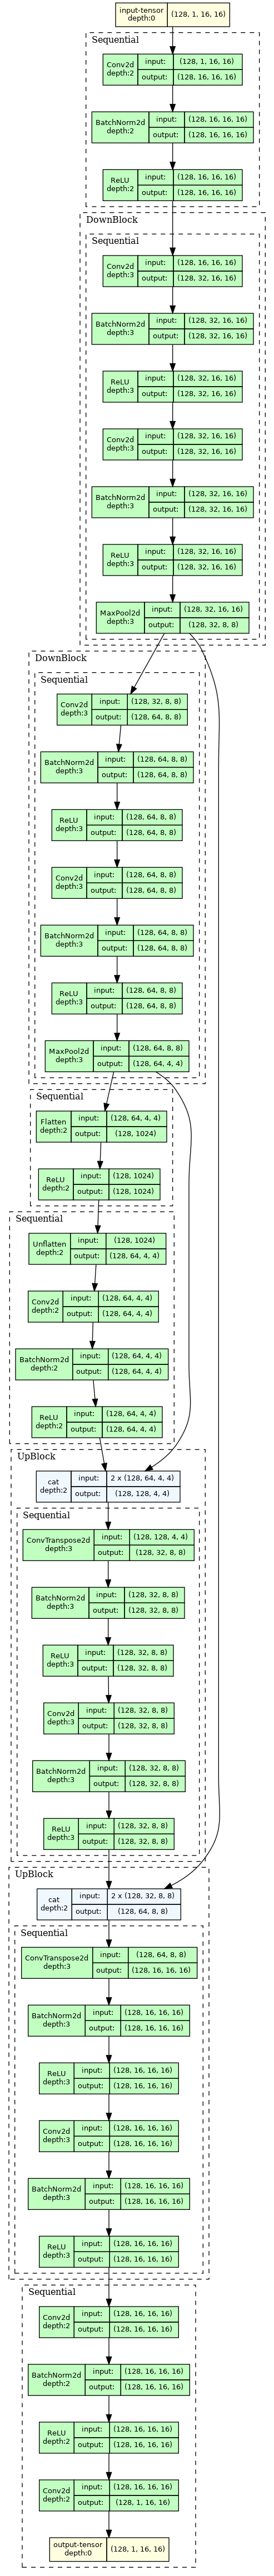

In [16]:
graphviz.set_jupyter_format('png') # 设置 graphviz 在 Jupyter Notebook 中的输出格式为 png 图片

model_graph = draw_graph(
    model, # 要绘制的模型实例
    input_size=(BATCH_SIZE, IMG_CH, IMG_SIZE, IMG_SIZE), # 输入数据的尺寸，用于确定模型输入的形状
    device='meta', # 指定模型运行的设备，这里设置为 'meta' 表示不实际运行模型，只进行结构绘制
    expand_nested=True # 是否展开嵌套的层，这里设置为 True 表示展开所有层
)

model_graph.resize_graph(scale=1.5) # 调整绘制的图形大小，将图形放大 1.5 倍
model_graph.visual_graph # 显示绘制的模型结构图


**代码逻辑解释:**

* **设置 graphviz 输出格式:**
    * `graphviz.set_jupyter_format('png')`: 将 graphviz 在 Jupyter Notebook 中的输出格式设置为 png 图片，以便在 Notebook 中直接显示模型结构图。

* **绘制模型结构图:**
    * `model_graph = draw_graph(model, input_size=(BATCH_SIZE, IMG_CH, IMG_SIZE, IMG_SIZE), device='meta', expand_nested=True)`: 
        * 使用 `draw_graph` 函数绘制模型结构图。
        * `model`:  要绘制的模型实例，这里使用的是之前定义的 `UNet` 模型。
        * `input_size`: 输入数据的尺寸，用于确定模型输入的形状，这里使用的是一个 batch 数据的尺寸。
        * `device='meta'`: 指定模型运行的设备为 'meta'，表示不实际运行模型，只进行结构绘制。
        * `expand_nested=True`:  设置为 True 表示展开所有嵌套的层，例如 `nn.Sequential` 模型中的所有层都会被展开。

* **调整图形大小:**
    * `model_graph.resize_graph(scale=1.5)`: 将绘制的图形放大 1.5 倍，使模型结构图更清晰。

* **显示图形:**
    * `model_graph.visual_graph`: 显示绘制的模型结构图。

**代码功能:**

这段代码使用 `torchview` 库中的 `draw_graph` 函数绘制 U-Net 模型的结构图，以便更好地可视化模型的结构，并帮助理解模型中各个层的连接关系。


在 [PyTorch 2.0](https://pytorch.org/get-started/pytorch-2.0/) 中，我们可以编译模型以加快训练速度。它会将操作列表发送到我们的 GPU，以便它可以像流水线一样对我们的输入应用这些操作。请参阅 [此处](https://pytorch.org/tutorials/intermediate/torch_compile_tutorial.html) 了解有关它的更多信息。


In [17]:
model = torch.compile(UNet().to(device)) # 将 UNet 模型转换为 TorchScript 模型，并在指定设备上运行


**代码逻辑解释:**

* **创建模型并移动到指定设备:** 
    * `UNet().to(device)`: 实例化一个 UNet 模型，并将其移动到指定的设备（`device`）上。
* **转换为 TorchScript 模型:**
    * `torch.compile(model)`: 使用 `torch.compile` 函数将模型转换为 TorchScript 模型。

**TorchScript 模型的优势:**

* **高效推理:** TorchScript 模型可以被编译成高度优化的机器码，从而提高模型的推理效率。
* **部署方便:** TorchScript 模型可以被保存为独立的模型文件，方便在不同的环境中部署，例如在生产环境中进行模型预测。
* **安全性:** TorchScript 模型可以防止模型在推理过程中被修改，增强模型的安全性。

**代码功能:**

这段代码将 U-Net 模型转换为 TorchScript 模型，以便在生产环境中进行高效部署和推理。


## 1.3 训练
| Training

让我们尝试将噪声添加到我们的图像中，看看我们的 U-Net 模型是否可以过滤掉它。我们可以定义一个参数 `beta` 来表示我们的图像中噪声占原始图像的百分比。我们可以使用 `alpha` 来表示 `beta` 的 [补集](https://brilliant.org/wiki/probability-by-complement/)。

In [18]:
def add_noise(imgs):
    dev = imgs.device # 获取输入图像的设备
    percent = .5 # 噪声比例，可以调整，取值范围为 0 到 1
    beta = torch.tensor(percent, device=dev) # 将噪声比例转换为张量，并移动到指定设备
    alpha = torch.tensor(1 - percent, device=dev) # 计算图像比例
    noise = torch.randn_like(imgs) # 生成与输入图像形状相同的随机噪声
    return alpha * imgs + beta * noise # 将原始图像与噪声进行加权叠加，得到带噪声的图像


**代码逻辑解释:**

* **获取设备:**
    * `dev = imgs.device`: 获取输入图像 `imgs` 所在的设备，例如 CPU 或 GPU。

* **设置噪声比例:**
    * `percent = .5`:  定义噪声比例，可以根据需要调整，取值范围为 0 到 1。
        *  `percent=0` 表示不添加噪声。
        *  `percent=1` 表示完全用随机噪声替换原始图像。

* **创建张量:**
    * `beta = torch.tensor(percent, device=dev)`: 将噪声比例 `percent` 转换为张量，并移动到指定设备 `dev`。
    * `alpha = torch.tensor(1 - percent, device=dev)`: 计算原始图像的比例。

* **生成随机噪声:**
    * `noise = torch.randn_like(imgs)`: 生成与输入图像 `imgs` 形状相同的随机噪声，每个像素的值服从标准正态分布。

* **添加噪声:**
    * `return alpha * imgs + beta * noise`: 将原始图像 `imgs` 与噪声 `noise` 进行加权叠加，得到带噪声的图像。
        *  `alpha * imgs`: 表示原始图像的权重。
        *  `beta * noise`: 表示噪声的权重。


**代码功能:**

这段代码定义了一个 `add_noise` 函数，用于向输入图像添加随机噪声。这个函数可以用来对图像进行噪声处理，模拟现实世界中图像采集过程中的噪声干扰，或者在训练去噪模型时作为数据增强的一部分。

通过调整噪声比例 `percent`，可以控制添加的噪声强度。


接下来，我们将定义我们的损失函数(loss function)，即原始(original)图像和预测(predicted)图像之间的 [均方误差(Mean Squared Error)](https://developers.google.com/machine-learning/glossary#mean-squared-error-mse)。


In [19]:
def get_loss(model, imgs):
    imgs_noisy = add_noise(imgs) # 对输入图像添加噪声
    imgs_pred = model(imgs_noisy) # 使用模型对带噪声的图像进行预测
    return F.mse_loss(imgs, imgs_pred) # 计算预测结果与原始图像之间的均方误差损失


**代码逻辑解释:**

* **添加噪声:**
    * `imgs_noisy = add_noise(imgs)`: 使用 `add_noise` 函数对输入图像 `imgs` 添加随机噪声，得到带噪声的图像 `imgs_noisy`。

* **模型预测:**
    * `imgs_pred = model(imgs_noisy)`: 将带噪声的图像 `imgs_noisy` 输入模型 `model` 进行预测，得到模型的预测结果 `imgs_pred`。

* **计算损失:**
    * `return F.mse_loss(imgs, imgs_pred)`: 
        * 使用 `F.mse_loss` 函数计算预测结果 `imgs_pred` 与原始图像 `imgs` 之间的均方误差损失 (Mean Squared Error Loss)。
        * 均方误差损失用于衡量预测结果与真实结果之间的差距，误差越小，说明模型的预测效果越好。





**代码功能:**

这段代码定义了一个 `get_loss` 函数，用于计算模型的损失。该函数接收模型 `model` 和输入图像 `imgs` 作为参数，并返回模型的损失值。

这个函数在训练模型时会用到，通过不断最小化损失值来优化模型的参数，使模型能够更准确地从带噪声的图像中恢复出原始图像。


为了显示模型的输出，我们需要将其转换回 CPU 上图像的格式。

In [20]:
def show_tensor_image(image):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2), # 将张量的值重新映射到 0 到 1 之间
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)), # 将张量中的任何大于 1 的值限制为 1
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)), # 将张量中的任何小于 0 的值限制为 0
        transforms.ToPILImage(), # 将张量转换为 PIL Image 对象
    ])
    plt.imshow(reverse_transforms(image[0].detach().cpu())) # 使用 matplotlib 显示图像


**代码逻辑解释:**

* **定义反向变换:**
    * `reverse_transforms = transforms.Compose([...]):` 创建一个由多个变换组成的 `transforms.Compose` 对象，用于将张量转换为可视化的图像。 
    *  `transforms.Lambda(lambda t: (t + 1) / 2)`: 将张量值从 -1 到 1 重新映射到 0 到 1 之间，以便可以用 matplotlib 显示。
    *  `transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t))`: 将张量中的任何大于 1 的值限制为 1，确保图像像素值在 0 到 1 之间。
    *  `transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t))`: 将张量中的任何小于 0 的值限制为 0，确保图像像素值在 0 到 1 之间。
    *  `transforms.ToPILImage()`:  将张量转换为 PIL Image 对象，以便可以使用 `matplotlib.pyplot.imshow` 函数显示。


* **显示图像:**
    * `plt.imshow(reverse_transforms(image[0].detach().cpu()))`: 
        * 使用 `image[0].detach().cpu()` 获取输入图像张量 `image` 的第一个元素，并将其从 GPU 移动到 CPU  并将其从计算图中分离。
        * 使用 `reverse_transforms` 对处理后的张量进行变换，使其可以被 `plt.imshow` 函数显示。
        * 使用 `plt.imshow` 函数显示处理后的图像。


**代码功能:**

这段代码定义了一个  `show_tensor_image` 函数，用于将 PyTorch 张量数据转换为可视化的图像，并使用 `matplotlib` 库进行显示。


由于 PyTorch 中的张量数据通常处于 -1 到 1 的范围内，而 `matplotlib` 库需要 0 到 1 的范围，所以需要进行一些变换才能将张量转换为可视化图像。


为了在训练期间查看改进，我们可以使用 [子图(subplots)](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplot.html) 来比较 `原始(Original)` 图像、`添加了噪声(Noise Added)` 的图像和 `预测的原始(Predicted Original)` 图像。

[@torch.no_grad](https://pytorch.org/docs/stable/generated/torch.no_grad.html) 将跳过使用此函数在训练期间计算梯度(gradient)。


In [21]:
@torch.no_grad() # 使用 @torch.no_grad() 装饰器，表示这段代码不需要进行梯度计算
def plot_sample(imgs):
    # 取 batch 中的第一张图像
    imgs = imgs[[0], :, :, :] 
    imgs_noisy = add_noise(imgs[[0], :, :, :]) # 对第一张图像添加噪声
    imgs_pred = model(imgs_noisy) # 使用模型对带噪声的图像进行预测，得到预测结果

    nrows = 1 # 图像展示的行数
    ncols = 3 # 图像展示的列数
    samples = {
        "Original" : imgs, # 存储原始图像
        "Noise Added" : imgs_noisy, # 存储添加噪声后的图像
        "Predicted Original" : imgs_pred # 存储模型预测的原始图像
    }
    for i, (title, img) in enumerate(samples.items()): # 循环遍历每个图像
        ax = plt.subplot(nrows, ncols, i+1) # 创建一个子图
        ax.set_title(title) # 设置子图标题
        show_tensor_image(img) # 显示图像
    plt.show() # 显示所有子图


**代码逻辑解释:**

* **使用 `@torch.no_grad()` 装饰器:**
    *  `@torch.no_grad()`: 使用 `@torch.no_grad()` 装饰器，表示这段代码不需要进行梯度计算。
        *  在训练模型时，需要计算梯度并进行参数更新。
        *  在测试模型或进行可视化时，不需要计算梯度，可以使用  `@torch.no_grad()` 装饰器来提高代码效率。

* **取 batch 中的第一张图像:**
    * `imgs = imgs[[0], :, :, :]`: 从输入图像 batch 中选取第一张图像，并将其存储在 `imgs` 中。

* **添加噪声和模型预测:**
    * `imgs_noisy = add_noise(imgs[[0], :, :, :])`: 对第一张图像添加噪声，得到带噪声的图像 `imgs_noisy`。
    * `imgs_pred = model(imgs_noisy)`: 使用模型 `model` 对带噪声的图像 `imgs_noisy` 进行预测，得到预测的原始图像 `imgs_pred`。

* **创建子图:**
    * `nrows = 1`:  设置图像展示的行数为 1 行。
    * `ncols = 3`:  设置图像展示的列数为 3 列。
    * `samples = {...}`: 创建一个字典，存储三个图像：原始图像、添加噪声后的图像、模型预测的原始图像。

* **循环遍历每个图像并显示:**
    * `for i, (title, img) in enumerate(samples.items()):`  循环遍历 `samples` 字典中的每个图像。
        * `i`: 图像的索引。
        * `title`: 图像的标题。
        * `img`: 图像张量。
    * `ax = plt.subplot(nrows, ncols, i+1)`: 创建一个子图，用于显示图像。
    * `ax.set_title(title)`:. 设置子图的标题为 `title`。
    * `show_tensor_image(img)`: 使用 `show_tensor_image` 函数显示图像 `img`。

* **显示所有子图:**
    * `plt.show()`: 显示所有子图。


**代码功能:**

这段代码定义了一个  `plot_sample` 函数，用于可视化模型的预测结果。该函数接收一个图像 batch 作为参数，并显示原始图像、添加噪声后的图像、模型预测的原始图像，以便观察模型的去噪效果。


最后，真相时刻到了！现在是训练我们的模型并观察其改进的时候了。

Epoch 0 | Step 000 Loss: 0.9251141548156738 


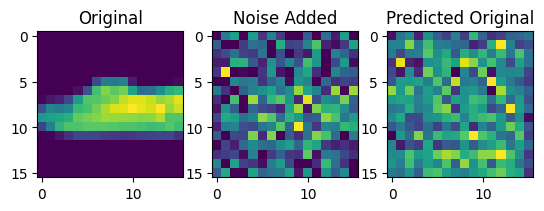

Epoch 0 | Step 100 Loss: 0.16490229964256287 


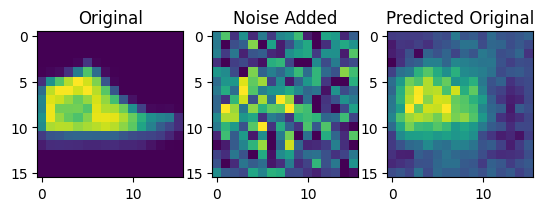

Epoch 0 | Step 200 Loss: 0.08121617138385773 


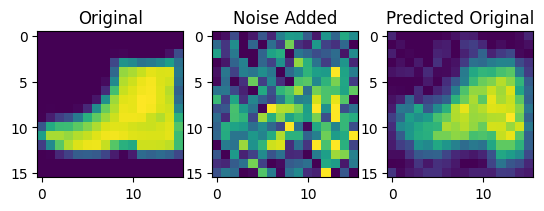

Epoch 0 | Step 300 Loss: 0.06832536309957504 


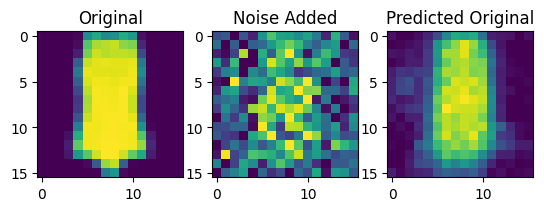

Epoch 0 | Step 400 Loss: 0.0651155337691307 


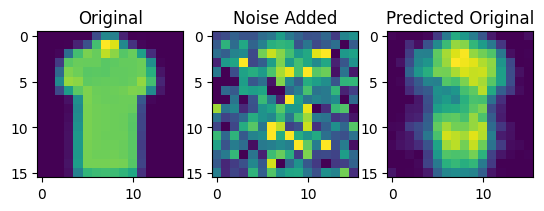

Epoch 0 | Step 500 Loss: 0.05861426889896393 


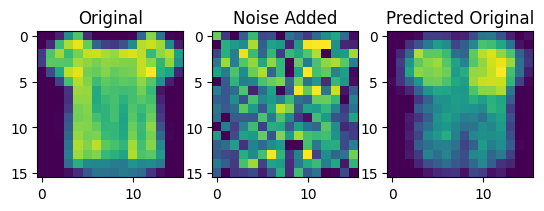

Epoch 1 | Step 000 Loss: 0.05864173546433449 


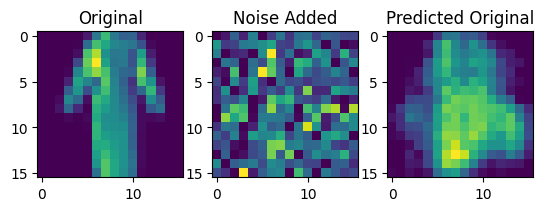

Epoch 1 | Step 100 Loss: 0.05452224612236023 


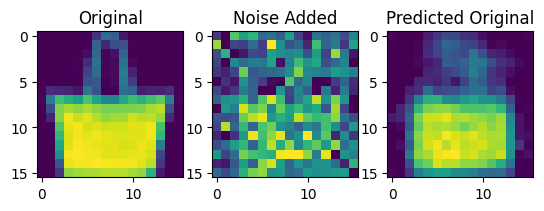

Epoch 1 | Step 200 Loss: 0.05550991743803024 


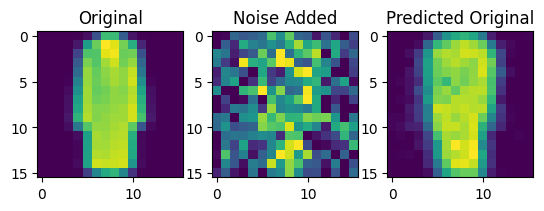

Epoch 1 | Step 300 Loss: 0.055380403995513916 


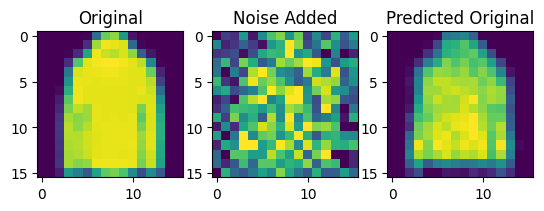

Epoch 1 | Step 400 Loss: 0.05433199927210808 


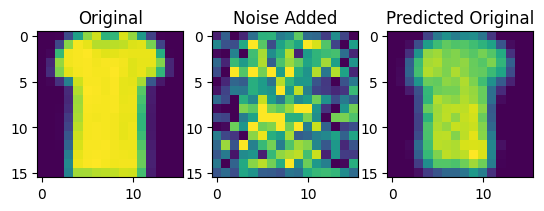

Epoch 1 | Step 500 Loss: 0.054314300417900085 


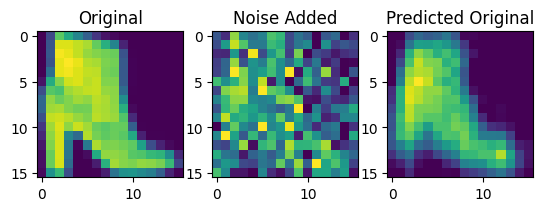

In [22]:
optimizer = Adam(model.parameters(), lr=0.0001) # 使用 Adam 优化器，设置学习率为 0.0001
epochs = 2 # 设置训练的总轮数为 2 轮

model.train() # 将模型设置为训练模式，启用梯度计算
for epoch in range(epochs): # 循环进行每一轮训练
    for step, batch in enumerate(dataloader): # 循环遍历每个 batch 数据
        optimizer.zero_grad() # 清空优化器的梯度

        images = batch[0].to(device) # 获取当前 batch 的图像数据，并将数据移动到指定设备
        loss = get_loss(model, images) # 计算模型的损失
        loss.backward() # 计算梯度
        optimizer.step() # 更新模型参数

        if epoch % 1 == 0 and step % 100 == 0: # 每 1 轮训练，每 100 步打印一次结果
            print(f"Epoch {epoch} | Step {step:03d} Loss: {loss.item()} ") # 打印当前轮次、步数和损失值
            plot_sample(images) # 显示当前 batch 中的图像及其噪声和预测结果


**代码逻辑解释:**

* **创建优化器:**
    * `optimizer = Adam(model.parameters(), lr=0.0001)`: 创建一个 Adam 优化器，并将其应用于模型的训练参数。
        * `model.parameters()`: 获取模型的所有参数。
        * `lr=0.0001`: 设置学习率为 0.0001，用于控制每次更新参数时的学习步长。

* **设置训练轮数:**
    * `epochs = 2`:  设置训练的总轮数为 2 轮。

* **设置模型为训练模式:**
    * `model.train()`: 将模型设置为训练模式，启用梯度计算。

* **循环遍历每个训练轮次:**
    * `for epoch in range(epochs):`: 循环进行每一轮训练。
    *  `epoch`: 当前的训练轮次。

* **循环遍历每个 batch 数据:**
    * `for step, batch in enumerate(dataloader):`: 循环遍历每个 batch 数据。
    *  `step`: 当前 batch 的步数。
    *  `batch`: 当前 batch 的数据。

* **清空优化器的梯度:**
    * `optimizer.zero_grad()`:  清空优化器的梯度，确保梯度计算从零开始。

* **获取图像数据:**
    * `images = batch[0].to(device)`: 获取当前 batch 的图像数据 `batch[0]`，并将其移动到指定设备 `device` 上。

* **计算损失和梯度:**
    * `loss = get_loss(model, images)`: 使用  `get_loss` 函数计算模型的损失。
    * `loss.backward()`:  计算损失函数关于模型参数的梯度。

* **更新模型参数:**
    * `optimizer.step()`: 使用优化器 `optimizer` 根据计算的梯度更新模型参数。

* **打印结果和可视化:**
    * `if epoch % 1 == 0 and step % 100 == 0`:  每 1 轮训练，每 100 步打印一次结果和可视化。
        * `print(f"Epoch {epoch} | Step {step:03d} Loss: {loss.item()} ")`: 打印当前轮次、步数和损失值。   
        * `plot_sample(images)`:  使用 `plot_sample` 函数显示当前 batch 中的图像及其噪声和预测结果。




**代码功能:**

这段代码使用 PyTorch 训练 U-Net 模型，以便从带噪声的图像中恢复出原始图像。训练过程包括以下步骤：

*  初始化模型、优化器和训练轮数。
*  将模型设置为训练模式，启用梯度计算。
*  循环进行每一轮训练。
*  在每一轮训练中，循环遍历每个 batch 数据。
*  对每个 batch 数据进行训练，包括计算损失、计算梯度和更新模型参数。
*  定期打印训练结果和可视化预测结果。


预测的图像中有一点噪声，但它仍然很好地提取了原始的服装。

现在，当给模型提供纯噪声时，它会如何表现？它可以创建可信的新图像吗？

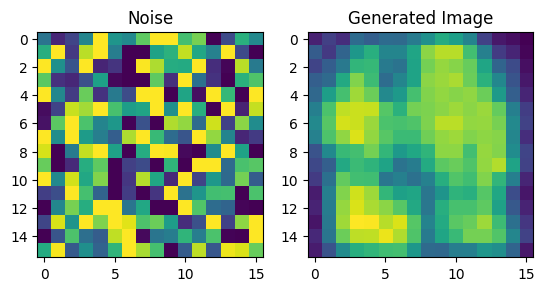

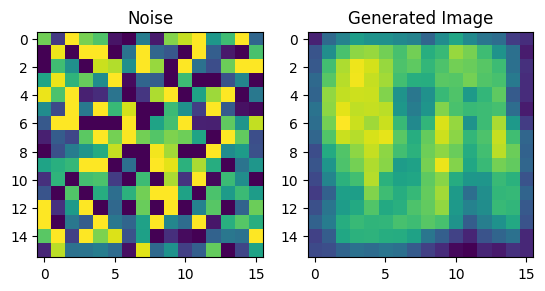

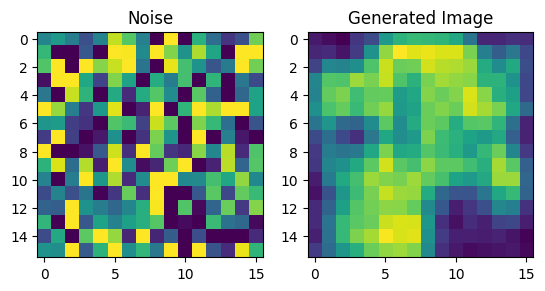

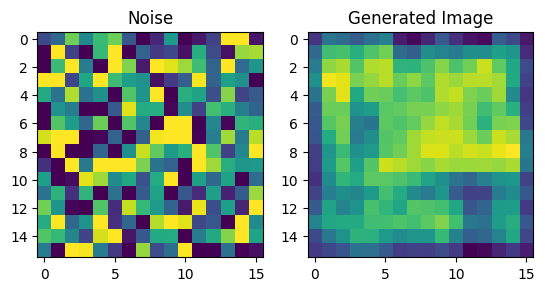

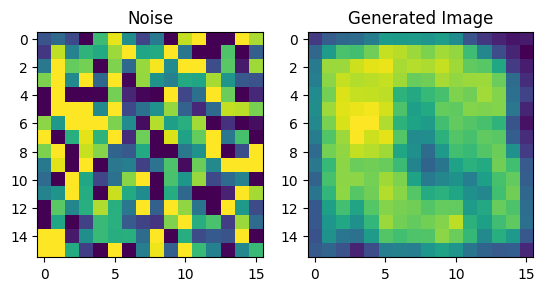

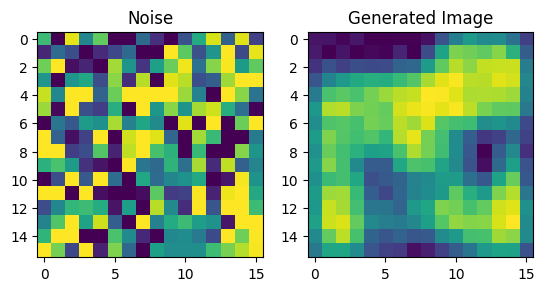

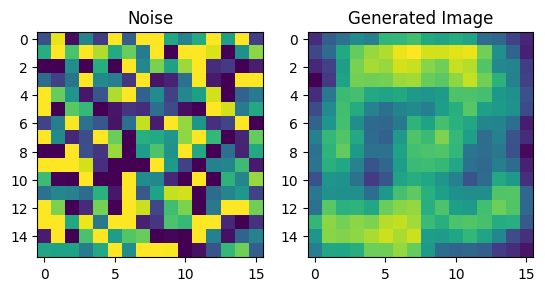

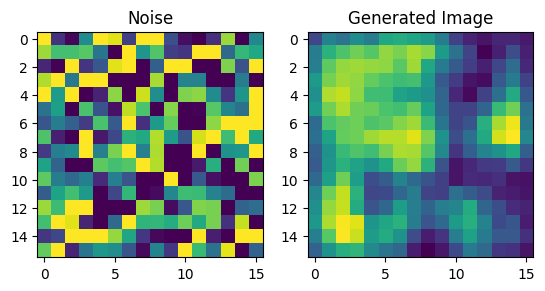

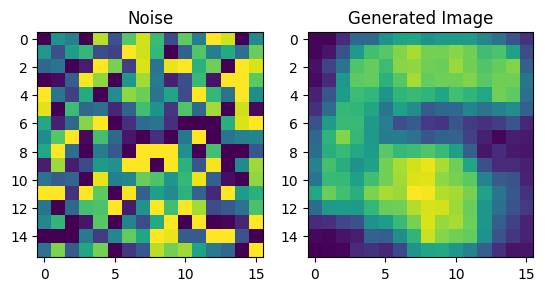

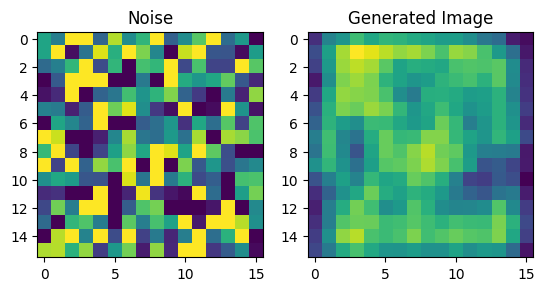

In [23]:
model.eval() # 将模型设置为评估模式，关闭梯度计算
for _ in range(10): # 循环生成并显示 10 张图像
    noise = torch.randn((1, IMG_CH, IMG_SIZE, IMG_SIZE), device=device) # 生成一个随机噪声张量，作为模型的输入
    result = model(noise) # 使用模型对噪声进行预测，得到生成的图像
    nrows = 1 # 图像展示的行数
    ncols = 2 # 图像展示的列数
    samples = {
        "Noise" : noise, # 存储噪声图像
        "Generated Image" : result # 存储生成图像
    }
    for i, (title, img) in enumerate(samples.items()): # 循环遍历每个图像
        ax = plt.subplot(nrows, ncols, i+1) # 创建一个子图
        ax.set_title(title) # 设置子图标题
        show_tensor_image(img) # 显示图像
    plt.show() # 显示所有子图


**代码逻辑解释:**

* **设置模型为评估模式:**
    * `model.eval()`: 将模型设置为评估模式，关闭梯度计算。
        * 在评估或推理时不需要进行梯度计算，可以使用 `model.eval()` 来提高效率。

* **生成随机噪声:**
    * `noise = torch.randn((1, IMG_CH, IMG_SIZE, IMG_SIZE), device=device)`: 生成一个随机噪声张量，作为模型的输入。
        * `torch.randn`: 生成一个服从标准正态分布的随机张量。
        * `(1, IMG_CH, IMG_SIZE, IMG_SIZE)`:  指定噪声张量的尺寸，与输入图像的尺寸相同。
        * `device=device`:  将张量移动到指定的设备 `device` 上。

* **使用模型进行预测:**
    * `result = model(noise)`: 使用模型 `model` 对噪声 `noise` 进行预测，得到生成的图像结果 `result`。

* **创建子图:**
    * `nrows = 1`: 设置图像展示的行数为 1 行。
    * `ncols = 2`: 设置图像展示的列数为 2 列。
    * `samples = {...}`: 创建一个字典，存储噪声图像和生成的图像。

* **循环遍历图像并显示:**
    * `for i, (title, img) in enumerate(samples.items()):` 循环遍历 `samples` 字典中的每个图像。
        * `i`: 图像的索引。
        * `title`: 图像的标题。
        * `img`: 图像张量。
    * `ax = plt.subplot(nrows, ncols, i+1)`:  创建一个子图，用于显示图像。
    * `ax.set_title(title)`:   设置子图的标题为 `title`。
    * `show_tensor_image(img)`:  使用 `show_tensor_image` 函数显示图像 `img`。

* **显示所有子图:**
    * `plt.show()`:  显示所有子图。


**代码功能:**

这段代码使用训练好的 U-Net 模型生成新的图像。它随机生成噪声，并将噪声输入到模型中，模型会生成与输入噪声相对应的图像。代码会显示生成的图像以及对应的噪声，以便观察模型的生成能力。


## 下一步
| Next

嗯，这些图像看起来更像是墨迹图像而不是服装。在下一个笔记本中，我们将改进这项技术，以创建更可识别的图像。

在继续之前，请通过运行下面的代码单元格来重启 Jupyter 内核。这将防止在以后的笔记本中出现内存问题。

In [24]:
import IPython # 导入 IPython 库
app = IPython.Application.instance() # 获取 IPython 应用实例
app.kernel.do_shutdown(True) # 关闭当前的 IPython 内核


{'status': 'ok', 'restart': True}

**代码逻辑解释:**

* **导入 IPython 库:**
    * `import IPython`: 导入 `IPython` 库，用于与 IPython 环境进行交互。

* **获取 IPython 应用实例:**
    * `app = IPython.Application.instance()`: 获取当前 IPython 应用的实例，以便访问 IPython 的功能。

* **关闭 IPython 内核:**
    *  `app.kernel.do_shutdown(True)`: 关闭当前的 IPython 内核。
        * `app.kernel`: 获取当前内核的实例。
        * `do_shutdown(True)`: 关闭内核，其中 `True` 表示强制关闭，即使有未完成的任务。

**代码功能:**

这段代码用于关闭当前的  IPython 内核。 在某些情况下，例如需要重新启动内核或者退出 IPython 环境时，可以使用这段代码来关闭内核。


![DLI Header](images/DLI_Header.png)